# Fraud_detection_using_text


# Types of useful text data

Emails from employees and/or clients

Descriptions of bank transcations

Employee notes

Insurance claims form description box

Recorded telephone conversations

# Text mining techniques for fraud detection
When using text data in fraud analysis, there are multiple ways to use the data.

Word search : A common application is a word search, to flag any data mentioning certain terms.

Sentiment Analysis : measuring how positive or negative a text is can be combined with word search. We can check whether text data associated with fraud tends to be more negative or positive relative to the normal text.

Word frequencies and topic analysis : Topic analysis and counting the frequency of certain words of interest, is another powerful application for fraud detection.

Style : Analyze the style of text data and search for text that is similar in style to flag for fraud.

## Word search for fraud detection

Flagging suspicious words : Suppose we want to flag all client transcations that mention a certain gambling company, as this company has received bad press lately. A simple word search on all transcations and client emails can easily filter whether any of the clients mention this company.

We can then use this result as a filter, or a flag on its own, or simply as an additional feature in our ML model.

**word counts to flag fraud with pandas**

Pandas has functions that allow us to do operations on text data within a pandas series or dataframe. Here we use str.contains function to find all rows that contain the word money laundering.

In [ ]:
# using a string operator to find words
df['email_body'].str.contains('money laundering')

# select data the matches
df.loc[df['email_body'].str.contains('money laundering', na=False)]

# the need to use na=False is to ignore all rows containing missing values, otherwise the indexer won't work.

# create a list of words to search for
list_of_words = ['police', 'money laundering']
df.loc[df['email_body'].str.contains('|'.join(list_of_words), na=False)] 

# we need to join the list of words with the "or" command 

# create a fraud flag
df['flag'] = np.where((df['email_body'].str.contains('|'.join(list_of_words)) == True), 1 ,0)

## More Text mining techniques
Cleaning our text data

Whenever we work with text data, be it for word search, topic modelling, sentiment analysis or text style, we need to do some rigorous text cleaning in order to be able to work with the data.
Must do's when working with textual data

Tokenization and lowercase with puncutation removing

Remove all stopwords as they mess up our data

Lemmatize words : chaning words from third person into first person, changing verbs in past and future tenses into present tenses. This allows us to combine all words that points to the same thing.

Stem words : reduce words to their root form. For e.g walking and walk

Data preprocessing

In [ ]:
# 1. Tokenization
from nltk import word_tokenize

text = df.apply(lambda row:word_tokenize(row['email_body']), axis=1)
text = text.rstrip()  # remove whitespaces
text = re.sub(r'[^a-zA-Z]', ' ', text) # lowercasing using re

# 2. Remove all stopwords and punctutaions
from nltk.corpus import stopwords
import string

exclude = set(string.punctuation)
stop = set(stopwords.words('english'))
stop_free = " ".join([word for word in text if ((word not in stop) and (not word.isdigit()))])
punc_free = " ".join(word for word in stop_free if word not in exclude)

In [ ]:
# Lemmatize words
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())

# Stem words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
cleaned_text = " ".join(porter.stem(token) for token in normalized.split())

# Topic modelling on fraud

Topic modelling : discover hidden patterns in text data

Topic modelling can be a powerful tool when searching for fraud in text data.

Topic modelling allows us to discover abstract "topics" that occur in a collection of documents.

Intutively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently.

Topic modelling therefore tells us in a very efficient way what the text is about, based on the words it contains.

Conceptually it is similar to clustering, as it clusters words belonging to the same topic together.

If we have text data of known fraud cases, it allows us to check what are the most common topics for those fraud cases and use that to compare unknown cases. In other words, compare topics for those fraud cases and use that to compare unknown cases.

Without known labels, we can inspect which topics seem to point to fraudulent behaviour and are interesting to further investigate.

## Latent Dirichlet Allocation (LDA)
LDA is an example of topic model and is commonly used.

LDA creates a "topic per text item" model and "words per topic" model, which are called Dirichlet distributions.

## Creating our own topic model
Clean the data

Then, create a dictionary containing which words appear how often in all of the text.And also a corpus, containing for each text line in our data the count of words that appear. -> Create a bag of words with dictionary and corpus

The results that we get from this model are two fold:

First we see how each word in our total data is associated with each topic.

Second, we can also see how each text item in our data associates with topics, also in the form of probabilitie

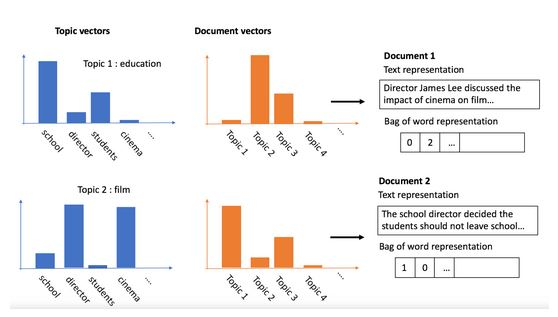

# Implementing LDA with gensim, Bag of words : dictionary and corpus

In [ ]:
from gensim import corpora

# use Dictionary function in corpora to create a dictionary from a text data, in this case cleaned emails.

# create dictionary of number of times a word appears
dictionary = corpora.Dictionary(cleaned_emails)

# filter out non frequent words : filter out words that appear in less than 5 emails and keep only the 50000 most frequent words, in a way of cleaning out the outlier noise of the text data.
dictionary.filter_extremes(no_below=5, keep_n=50000)

# create a corpus that tells us for each email how many words it contains and how many times those words appear
# Doc2bow stands for "document to bag of words". This function converts text data into bag-of-words format. That means each row in our data is now a list of words with their associated word count.
corpus = [dictionary.doc2bow(text) for text in cleaned_emails]

After cleaning the text data, and creating dictionary and corpus, we are now ready to run our LDA model.

We need to pass the corpus and dictionary into the LDA model.

As with k-means, we need to pick the number of topics we want to obtain beforehand, even if we're not sure yet what the topics are.

The LDA model calculated here, now contains the associated words for each topic, and the topic scores per email.

We can obtain the top words from the three topics with the function "print_topics"

After running the model, we print the 3 topics and the four top keywords associated with the topic, for interpretation of results

In [ ]:
import gensim

# define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# print the 3 topics from the model with top words
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

# Flagging fraud based on topics

Using LDA model results for fraud detection
If we don't have labels, we can first check for frequency of suspicious words within topics and check whether topics seem to describe the fraudulent behaviour.

For the Enron email data, a suspicious topic would be one where employees are discussing stock bonuses, selling stock, the Enron stock price, and perhaps mentions of accounting or weak financials.

Defining suspicious topics does require some pre-knowledge about the fraudulent behaviour. If the fraudulent topic is noticeable, we can flag all instances that have a high probability for this topic.

If we have previous cases of fraud, we can run a topic model on the fraud text only, as well as on the non-fraud text. Check whether the results are similar i.e whether the frequency of topics are the same in fraud versus non-fraud.

Lastly, we can check whether fraud cases have a higher probability score for certain topics. If so, we can run a topic model on the new data and create a flag directly on the instances that score high on those topics.

## To understand topics, we need to visualize

Interpretation of the abstract topics can someti
mes be difficult, so we need good visualization tools to dive deeper and try to understand what the underlying topics mean.

There is a visualization tool called pyLDAvis for gensim available, that does an excellent job. Be minfull though, this tool only works with Jupyter notebooks. Once we have created our model, we can create a detailed visualisation in just 2 lines of code

In [ ]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_display)

Interpreting the output

Each bubble on the left-hand side represents a topic. The larger the bubble, the more prevalent that topic is. We can click on each topic to get the details per topic in the right panel.

The words are the most important keywords that form the selected topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart.

A model with too many topics, will typically have many overlaps, or small sized bubbles clustered in one region. In our case, there is a slight overlap between topics 2 & 3, so that may point to 1 topic too many.


# Practical application : Assign topics to original data

One of the practical application of topic modelling is to determine what topic a given text is about. To find that, we need to find the topic number that has the highest percentage contribution in that text
.
The below function nicely aggregates this information in a presentable tab

In [ ]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

Function can be applied as follows:

In [ ]:
contents = pd.DataFrame({'Original text':text_clean})
topic_details = pd.concat([get_topic_details(ldamodel,
                           corpus), contents], axis=1)
topic_details.head()

Result : Each row contains the dominant topic number, the probability score with that topic and the original text dat

# Exercise

https://github.com/Simonm952/NLP-Spacy/blob/main/Text%20Mining.ipynb



# NLP Feature Engineering


One-hot encoding with pandas using get_dummies

In [ ]:
import pandas as pd

df = pd.get_dummies(df, columns=['sex'])

# Text Preprocessing : Tokenization and Lemmatization
Converting words into lowercase
Removing leading and trailing whitespaces
Removing punctuations
Removing stopwords
Expanding contractions
Removing special characters (numbers, emojis, etc)

## Tokenization using spaCy

In [ ]:
import spacy

# load the english model en_core_web_sm model
nlp = spacy.load('en_core_web_sm')

string = "Hello! I don't know what I'm doing here"

# create a Doc object
doc = nlp(string)

# doc object contains required tokens and many other things
# Generate list of tokens
tokens = [token.text for token in doc]
print(tokens)

['Hello', '!', 'I', 'do', "n't", 'know', 'what', 'I', "'m", 'doing', 'here']


## Lemmatization using spacy
Convert into its base form
reducing, reduces, reduced, reduction -> reduce
am, are, is -> be
Lemmatization converts words with apostrophe into full -forms.
n't -> not
've -> have
Similar to extracting token using spacy

In [ ]:
lemmas = [token.lemma_ for token in doc]

In [ ]:
print(lemmas)

['hello', '!', '-PRON-', 'do', 'not', 'know', 'what', '-PRON-', 'be', 'do', 'here']


## Part-of-speech tagging
Used in Word-sense disambiguation to identify the sense of the word in a sentence.

For instance consider the sentences : "The bear is a majestic animal" and "Please bear with me".

Both sentences use the word bear , but means different things.

POS tagging helps in identifying this distinction by identifying one bear as a noun and other as a verb.

Also used in sentiment analysis, question answering, fake news and opinion spam detection

POS tagging using Spacy

POS tagging is easy to do using spacy models and performing it is almost identical to generating tokens or lemmas.


In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

string = "Jane is an amazing guitarist"

doc = nlp(string)

# generate the list of tokens and pos tags
pos = [(token.text, token.pos_) for token in doc]
print(pos)

[('Jane', 'PROPN'), ('is', 'AUX'), ('an', 'DET'), ('amazing', 'ADJ'), ('guitarist', 'NOUN')]


Spacy inferes the POS tagging based on the predictions given by its pre-trained model
Accuracy of POS tagging depends on the data the model has been trained on.

# Advanced spacy

In [ ]:
# import the english language class
from spacy.lang.en import English

# create the nlp object
nlp = English()

we can use the nlp object like a function to analyze text. Contains the preprcoessing pipeline. It also includes language specific rules used for tokenizing the text into words and punctuation.

## The Doc object

When we process a text with the nlp object, spacy creates a Doc object - short for "document".

In [ ]:
# created by processing a string of text with the nlp object
doc = nlp("Hello world!")

# iterate over tokens in a doc
for token in doc:
    print(token.text)
    
token = doc[1]

print(token.text)

Hello
world
!
world


## The Span object
A span object is a slice of the document consisting of one or more tokens. It's only a view of the doc and doesn't contain any data itself. To create a span we can use python slicing

In [ ]:
# a slice from the Doc is a span object
span = doc[1:4]

print(span.text)

world!


In [ ]:
doc = nlp("It costs $5.")

print("Index: ", [token.i for token in doc])
print("Text: ", [token.text for token in doc])
print("is_alpha:", [token.is_alpha for token in doc])
print("is_punct:", [token.is_punct for token in doc])
print("like_num:", [token.like_num for token in doc])

Index:  [0, 1, 2, 3, 4]
Text:  ['It', 'costs', '$', '5', '.']
is_alpha: [True, True, False, False, False]
is_punct: [False, False, False, False, True]
like_num: [False, False, False, True, False]


# Statistical models
Enables spacy to predict linguistic attributes in context e.g Part-of-speech tags, syntatic dependencies, named entities trained on labeled example texts.
en_core_web_sm package is a small English model that supports all core capabilities and is trained on web text.

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

***Predicting Part-of-speech tags***

In [ ]:
import spacy

# load the small English model
nlp = spacy.load('en_core_web_sm')

# process the text
doc = nlp("She ate the pizza")

# Iterate over the tokens
for token in doc:
    # print the text and the predicted part-of-speech tag
    print(token.text, token.pos_)

She PRON
ate VERB
the DET
pizza NOUN


**redicting the Syntactic Dependencies**

In addition to the part-of-the-speech tags, we can also predict how the words are related. For example, whether a word is the subject of the sentence or an object.

Spacy uses a standardized labels scheme.

The "dep underscore" attribute returns the predicted dependency labe

In [ ]:
# process a text
doc = nlp(u"Apple is looking at buying U.K startup for $1 billion")

#iterate over the predicted entities
for ent in doc.ents:
    print(ent.text, ent.label_)

Apple ORG
U.K ORG
$1 billion MONEY


The explain method

To get definitions for the most common tags and labels.

In [ ]:
spacy.explain("ORG")

'Companies, agencies, institutions, etc.'

## Rule based matching
Why not regular expressions

Spacy's matcher let's us write rules to find words and phrases in text. Compared to regular expressions, the matcher workds with DOc and token objects instead of only strings.

It's also more flexibe : we can search for texts but also other lexical attributes.

We can even write rules that use the model's predictions. For example, find the word "duck" only if it's a verb, not a noun

## Match patterns
Match patterns are lists of dictionaries. Each dictionary describes one token. The keys are the names of the token attributes, mapped to their expected values.

E.g [{'ORTH':'iPhone'}, {'ORTH':'X'}] . In this example, we're looking for two tokens with the text "iPhone" and "X". We can also match on other token attributes.

E.g [{'LOWER':'iphone'}, {'LOWER':'x'}]. Here, we're looking for two tokens whose lowercase forms equal "iphone" and "x".

We can even write patterns using attributes predicted by the model. [{'LEMMA':'buy'}, {'POS':'NOUN'}] . Here we are matching a token with the lemma "buy", plus a noun. The lemma is the base form, so the pattern would match phrases like "buying milk" or "bought flowers".

In [ ]:
import spacy

# import the matcher
from spacy.matcher import Matcher

# load the model and create the nlp object
nlp = spacy.load('en_core_web_sm')

# initialize the matcher with the shared vocab
matcher = Matcher(nlp.vocab)

# add pattern to the matcher
pattern = [{'ORTH':'iPhone'}, {'ORTH':'X'}]

# the first argument is a unique ID to identify which pattern was matched,
# second argument is an optional callback, we don't need here so we set it to None
# third argument is the pattern
matcher.add('IPHONE_PATTERN', None, pattern)

# process some text
doc = nlp("New iPhone X release date leaked")

# call the matcher on the doc, it returns a list of tuples 
matches = matcher(doc)

# each tuple consists of 3 values : the match ID, the start index and the end index of the matched span
# match_id : hash value of the pattern name
# start : start index of matched span
# end : end index of matched span
# iterate over the matches
for match_id, start, end in matches:
    # get the matched span
    matched_span = doc[start:end]
    print(matched_span.text)
   

iPhone X


## Matching lexical attributes
5 tokens consisting of only digits. Three case-insensitive tokens for 'fifa', 'world' and 'cup' and a token that consists of punctuation. The pattern matches the token "2018 FIFA World Cup:"


In [ ]:
pattern = [{"IS_DIGIT":True}, {"LOWER":'fifa'}, {"LOWER":"world"}, {"LOWER":"cup"},
            {"IS_PUNCT":True}]
doc = nlp("2018 FIFA World Cup : France won!")

In [ ]:
pattern = [{'LEMMA':'love', 'POS':'VERB'}, {'POS':'NOUN'}]

doc = nlp("I loved dogs but the now I love cats more")

Here we have 2 tokens. A verb with the lemma "love", followed by a noun. This pattern matches "loved dogs" and "love cat

## Using operators and quantifiers

In [ ]:
pattern = [{'LEMMA':'buy'},
           {'POS':'DET', 'OP':'?'}, # optional : match 0 or 1 times
           {'POS':'NOUN'}]
doc = nlp("I bought a smartphone. Now I'm buying apps.")

Operators and quantifiers lets us define how often a token should be matched. They can be added using the 'OP' key. Here the "?" operator makes the determiner token optional, so it will match a token with the lemma "buy", an optional article and a noun.

"OP" can have one of the four values

# Data Structures : Vocab, Lexemes and StringStore
Shared vocab and string store

spacy stores all shared data in a vocabulary, the Vocab. This includes words, but also the labels schemes for tags and entities. To save memory, all strings are encoded to hash IDs.

If a word occurs more than once, we don't need to save it every time. Instead, spacy uses a hash function to generate an ID and stores the string only once in the string store. The StringStore is available as nlp.vocab.strings.

StringStore : It's a lookup table that works in both directions. We can look up a string and get its hash, and look up a hash to get its string value. Internally, spacy only communicates in hash IDs.

In [ ]:
coffee_hash = nlp.vocab.strings['coffee']
coffee_string = nlp.vocab.strings[coffee_hash]

In [ ]:
# raises an error if we haven't seen the string before
string = nlp.vocab.strings[3197928453018144401]

## Lexemes : entries in the vocabulary
Lexemes are context-independent entries in the vocabulary. We can get a lexeme by looking up a string or a hash ID in the vocab.

Lexemes expose attributes just like tokens. They hold 
context-independent information about a word, like the text or whether the word consists of alphanumeric characters.

Lexemes don't have part-of-speech tags, dependencies or entity labels. Those depend on the context.

In [ ]:
doc = nlp("I love coffee")
lexeme = nlp.vocab['coffee']

# print the lexial attribute
print(lexeme.text, lexeme.orth, lexeme.is_alpha)

coffee 3197928453018144401 True


# Vocab, hashes and lexemes


The Doc contains words in context - in this case, the tokens "I", "love" and "coffee" with their part-of-speech tags and dependencies. Each token refers to a lexeme, which knows the word's hash ID.

To get the string representation of the word, spacy looks up the hash in the string store.

## Doc, Span and Token

## The Doc object

The Doc is one of the central data structures in spacy. It's created automatically when we process a text with the nlp object. But we can also instantiate the class manually.

After creating the nlp object, we can import the Doc class from spacy.tokens. Here we are creating a Doc from three words.

The Doc class takes 3 arguments : the shared vocab, the words and the spaces

In [ ]:
# create an nlp object
from spacy.lang.en import English
nlp = English()

# import the Doc class
from spacy.tokens import Doc

# the words and spaces to create the doc from
words = ['Hello', 'world', '!']
spaces = [True, False, False]

# create a doc manually
doc = Doc(nlp.vocab, words=words, spaces=spaces)

# The Span object

A span is a slice of a Doc consisting of one or more tokens.The Span takes at least 3 arguments : the doc it refers to, and the start and end index of the span. The end index is exclusive.

The doc ents are writable, so we can add entries manually by overwriting it with a list of spans

In [ ]:
from spacy.tokens import Doc, Span

# the words and spaces to create the doc from
words = ['Hello', 'world', '!']
spaces = [True, False, False]

# create a doc manually
doc = Doc(nlp.vocab, words=words, spaces=spaces)

# create a span manually
span = Span(doc, 0, 2)

# create a span with label
span_with_label = Span(doc, 0, 2, label="GREETING")

# add span to the doc.ents
doc.ents = [span_with_label]

## Best practices

The Doc and Span are very powerful and optimized for performance. They give us access to all references and relationships of the words and sentences.

If the application needs to output strings, make sure to convert the doc as late as possible. If we do it too early, we'll loose all relationship between the tokens.

To keep things consistent, use the built-in attributes wherever possible. For example token.i for the token index.

Don't forget to pass in the shared vocab.

# Word Vectors and semantic similarity

Use spacy to predict how similar documents, spans or tokens are to each other. Spacy can compare two objects and predict how similar they are - for example, documents, spans or single tokens.

The Doc, Token and Span objects have a .similarity() method that takes another object and returns a floating point number between 0 and 1, indicating how similar they are.

Inorder to use similarity, we need a larger spacy model that has word vectors included. For e.g the medium or large English model - but not the small one.

en_core_web_md (medium model) , en_core_web_lg (large model), en_core_web_sm (small model). So if we want to use vectors, always use a model that ends in "md" or "lg".

## Similarity example

In [ ]:
# load the medium English model with vectors
#nlp = spacy.load("en_core_web_md")

# compare two documents
doc1 = nlp("I like fast food")
doc2 = nlp("I like pizza")

print(doc1.similarity(doc2))

# compare two tokens
doc = nlp(" I like pizza and pasta")

token1 = doc[2]
token2 = doc[4]

print(token1.similarity(token2))

# we can also use the similarity method to compare different tyes of objects
# e.g a document and a token

doc = nlp("I like pizza")
token = nlp("soap")[0]

print(doc.similarity(token))

# compare a span with a document
span = nlp("I like pizza and pasta")[2:5]
doc = nlp("Mcdonalds sells burgers")

print(span.similarity(doc))

0.8018373287411041
-0.10890159
0.28162675424923095
0.2695567799922091


/usr/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead 

# How does spacy predict similarity?

Similarity is determined using word vectors, multi-dimensional representations of meanings of words. Vectors can be added to spacy's statistical models.

By default, the similarity returned by spacy is the cosine similarity between two vectors.

Doc and Span vectors default to the average of their token vectors. Short phrases are better than long documents with many irrelevant words. That's why we usually get more value out of shorter phrases with fewer irrelevant words.

# Word vectors in spacy

First, we load the medium model again which ships with word vectors.

In [ ]:

doc = nlp("I have a banana")

# access the vector via the token.vector attribute.
print(doc[3].vector)

# result is a 300-dimensional vector of the word banana

[ 0.9383564  -2.9524927   1.1866798   0.49744225 -0.11475766  0.804008
  0.4672468  -1.1062207   2.9193573   1.800931   -0.31358248  1.1920271
 -1.2406584  -2.3237133   2.099902   -0.66673994 -0.96991694  0.8316833
  0.10666084 -0.42245626  1.6402073   0.95437694  1.2855074  -2.038612
 -0.7317371  -0.17545497  0.14752543  1.327169    3.2502053  -3.9332502
  1.7409098  -0.73711336  1.4852796  -2.8246899  -1.8938334  -1.2638527
  5.298433   -1.2850044  -2.7470415  -1.5607052   5.181785    2.242096
 -2.1922808  -5.310454    1.0295098   1.484088   -1.5894104  -0.14745024
  1.7829046   1.8879583   4.152973   -3.1493165  -0.18937713  2.09369
 -2.1269834   0.63290507  2.6979058   1.800016   -2.3953576   2.54901
  1.0445759  -1.3137031   2.4631662  -0.07756937 -1.129545    0.1169464
  1.3869805   0.53586185 -2.242661    2.8641388  -3.8719153  -0.6409143
  0.6971829   4.484493   -1.6210997   2.494869    0.7218447  -3.3112261
 -0.2163549  -2.5339773  -1.1702836  -0.9627162  -3.7210062   1.559916

# Similarity depends on the application context

Similarity can be used for many applications: recommendation systems, flagging duplicates etc.

It's important to keep in mind that there's no objective definition of what's similar and what is'nt. It always depends on the context and what the application needs to do.

Example : spacy's default word vectors assign a very high similarity score to "I like cats" and "I hate cats". This makes sense, because both texts express sentiment about cats. But in a different application context, we might want to consider the phrases as very dissimilar, because they talk about opposite sentiments.

# Recap : Rule based Matching

In [ ]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

# patterns are list of dictionaries describing the tokens
pattern = [{'LEMMA':'love', 'POS':'VERB'}, {'LOWER':'cats'}]
# patterns can be added to the matcher using the matcher.add
matcher.add('LOVE_CATS', None,pattern)

# operators can specify how often a token should be matched
# '+' would match one or more times
pattern = [{'TEXT':'very', 'OP':'+'}, {'TEXT':'happy'}]

# calling matcher on doc object returns list of matches (match_id, start, end) tuples
doc = nlp("I love cats and I'm very very happy")
matches = matcher(doc)
print(matches)



[(9137535031263442622, 1, 3)]


# Adding statistical predictions

In [ ]:
matcher = Matcher(nlp.vocab)
matcher.add('DOG', None, [{'LOWER':'golden'}, {'LOWER':'retriever'}])
doc = nlp('I have a Golden Retriever')

for match_id, start, end in matcher(doc):
    span = doc[start:end]
    print("Matched span:", span.text)
    # get the span's root token and root head token
    print("Root token:", span.root.text)
    print("Root head token:", span.root.head.text)
    # get the previous token and its POS tag
    print('Previous token:', doc[start-1].text, doc[start-1].pos_)

Matched span: Golden Retriever
Root token: Retriever
Root head token: have
Previous token: a DET


If the span consists of more than one token, this will be the token that decides the category of the phrase. For e.g the root of "Golden Retriever" is "Retriever". We can also find the head token of the root. This is the synatic "parent" that governs the phrase - in this case, the verb "have".

We can also look at the previous token and its attributes. In this case, it's a determiner, the article "a".

## Efficient phrase matching
The phrase matcher is another helpful tool to find sequences of words in our data. If performs the keyword search on the document, but instead of only finding strings, it gives us direct access to the tokens in context. (PhraseMatcher is like regular expressions or keyword search - but with access to the tokens!)

It takes Doc objects as patterns. More efficient and faster than the Matcher. This makes it very useful for matching large dictionaries and word lists on large volumnes of text.

In [ ]:
from spacy.matcher import PhraseMatcher

matcher = PhraseMatcher(nlp.vocab)

# instead of list of dicts, we pass doc object as the pattern
pattern = nlp("Golden Retriever")
matcher.add('DOG', None, pattern)
doc = nlp("I have a Golden Retriever")

# iterate over the matches
for match_id, start, end in matcher(doc):
    # get the matched span
    span = doc[start:end]
    print("Matched span:", span.text)

Matched span: Golden Retriever


## Preprocessing pipelines
Preprocessing pipelines : a series of functions applied to a Doc to add attributes like part-of-speech tags, dependency labels or named entities.

What happens when we call nlp ?

In [ ]:
doc = nlp("This is a sentence")

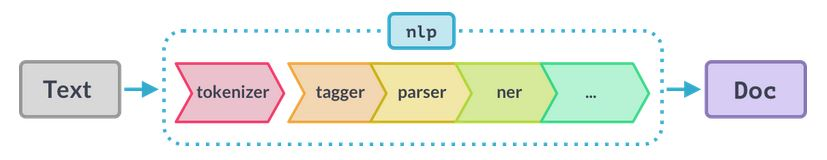

First the tokenizer is applied to turn the string of text into a Doc object.

Next a series of pipeline components is applied to the Doc in order. The tagger, then the parser, then the entity recognizer.

Finally, the processed Doc is returned, so we can work with it.

The text classifier sets category labels that apply to the whole text, and adds them to the doc.cats property. Because text categories are always very specific, the text classifier is not included in any of the pre-trained models by default. But we can use it to train our own system.

## Custom pipeline components
Custom pipeline components lets us add our own function to the spacy pipeline that is executed when we call the nlp object on a text. After the text is tokenized and a Doc object has been created, pipeline components are applied in order.

Custom components are executed automatically when we call the nlp object on a text. They are specially useful for adding our own custom metadata to documents and tokens. We can also use them to update built-on attributes, like the named entity spans.

# Anatomy of a component

Fundamentally, a pipeline component is a function or callable that takes a doc, modifies it and returns it, so it can be processed by the next component in the pipeline.
Components can be added to the pipeline using the nlp.add_pipe method.

To specify where to add the custom component in the pipeline, we can use following keyword arguments.

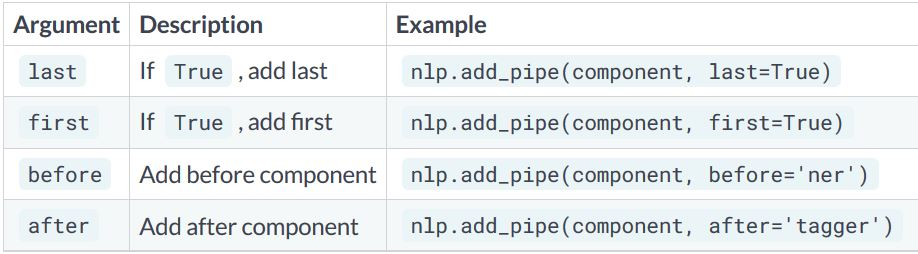

In [ ]:
# create the nlp object
nlp = spacy.load('en_core_web_sm')

# define a custom component
def custom_component(doc):
    # print the doc's length
    print('Doc length :', len(doc))
    # return the doc object
    return doc
    
# add the component first in the pipeline
nlp.add_pipe(custom_component, first=True)

print('Pipeline:', nlp.pipe_names)

#process a text
doc = nlp("hello world")

# Setting custom attributes
Custom attributes lets us add any meta data to Docs, Tokens and Spans. The data can be added once or it can be computed dynamically.

Custom attributes are available via to ._ property.

This makes it clear that they were added by the user, and not built into spacy, like token.text

In [ ]:
doc._.title = "My document"
token._.is_color = True
span._.has_color = False

In [ ]:
# import global classes
from spacy.tokens import Doc, Token, Span

# set extensions on the Doc, Token and Span
# in this case they have default values and can be overwritten
Doc.set_extension('title', default=None)
Token.set_extension('is_color', default=False)
Span.set_extension('has_color', default=False)

# Attribute extensions
Set a default value that can be overwritten. For e.g, a custom "is_color" attribute on the token that defaults to False. On individual tokens, its value can be changed by overwriting it - in this case, True for the token "blue"

In [ ]:
from spacy.tokens import Token

# set the extension on the Token with default value
Token.set_extension("is_color", default=False)

doc = nlp("The sky is blue.")

# overwrite the extension attribute value
doc[3]._.is_color = True

# Property extensions

Property extensions work like properties in python: they can define a getter function and an optional setter.

The getter function is only called when we retrieve the attribute. This let's us to compute the value dynamically, and even take other custom attributes into account.

Getter functions takes one argument : the object, in this case, the token. In the below example , the function returns whether the token text is in our list of colors.

We can then provide the function via the getter keyword argument when we register the extension. The token blue now returns True for is_color

If we want to set extension attributes on a Span, we almost always want to use a property extension with a getter. Otherwise, we would have to update every possible span ever by hand to set all the values.

In [ ]:
from spacy.tokens import Token

# define getter function
def get_is_color(token):
    colors = ['red', 'yellow', 'blue']
    return token.text in colors
# set extension on the token with getter
Token.set_extension('is_color', getter=get_is_color)

doc = nlp("The sky is blue.")
print(doc[3]._.is_color, '-', doc[3].text)

True - blue


In below example, the get_has_color function takes the span and returns whether the text of any of the tokens is in the list of colors.

In [ ]:
from spacy.tokens import Span

# define getter function
def get_has_color(span):
    colors = ['red', 'yellow', 'blue']
    return any(token.text in colors for token in span)
# set extension on the Span with getter
Span.set_extension('has_color', getter=get_has_color)
doc = nlp("The sky is blue.")
print(doc[1:4]._.has_color, '-', doc[1:4].text)
print(doc[0:2]._.has_color, '-', doc[0:2].text)

True - sky is blue
False - The sky


# Method extensions

Method extensions make the extension attribute a callable method. We can then pass one or more arguments to it, and compute attribute values dynamically- for e.g, based on a certain argument or setting.

Assigns a function that becomes available as an object method.

Let's us pass arguments to the extension function.

Below example checks whether the doc contains the token with the given text.The first argument of the method is always the object itself - in this case, the Doc. It's passed in automatically when the method is called.The custom has_token method returns True for the word "blue" and False for the word "cloud".

In [ ]:
from spacy.tokens import Doc

# define method with arguments
def has_token(doc, token_text):
    in_doc = token_text in [token.text for token in doc]
    
# set extension on the Doc with method
Doc.set_extension('has_token', method=has_token)
doc = nlp("the sky is blue.")

print(doc._.has_token('blue'), '-blue')
print(doc._.has_token('cloud'), '-cloud')

# Scaling and Performance
# Nieuwe sectie
Processing large volumes of text

If we need to process a lot of texts and create a lot of Doc objects in a row, the nlp.pipe object can speed it up significantly. It processes the texts as a stream and yields Doc objects.

It is much faster than just calling nlp on each text, because it batches up the texts. nlp.pipe is a generator that yields Doc objects, so inorder to get a list of Docs remember to call the list method around 

In [ ]:
# BAD

docs = [nlp(text) for text in LOTS_OF_TEXTS]

# GOOD

docs = list(nlp.pipe(LOTS_OF_TEXTS))

## Passing in context
nlp.pipe also supports passing in tuples of text/context if we set as_tuples to True. Let's us pass in (text, context) tuples.

The method will then yield (doc, context) tuples.

Useful for associating metadata with the doc

In [ ]:
data = [("This is a text", {'id': 1, 'page_number': 15}),
        ("And another text", {'id':2, 'page_number': 16}), ]

for doc, context in nlp.pipe(data, as_tuples=True):
    print(doc.text, context['page_number'])

We can even add the context meta data to custom attributes. In this e.g, we are registering two extensions, "id" and "page number", which is default to None. After processing the text and passing through the context, we can overwrite the doc extensions with our context metadata.

## Using only the tokenizer

ANother common scenario : Sometimes we already have a model loaded to do other processing, but we only need the tokenizer for one particular text.

Running the whole pipeline is unnecessarily slow, because we'll be getting a bunch of predictions from the model that we don't need. If we only need the tokenized Doc object, we can use the nlp.make_doc to turn text into a Doc object. This is also how spacy does it behind the scenes. nlp.make_doc turns the text into a Doc before the pipeline components are called.

In [ ]:
# BAD
doc = nlp("Hello world")

# GOOD
doc = nlp.make_doc("Hello world")

# Disabling pipeline components

spacy also allows us to temporarily disable pipeline components using the nlp.disable_pipes context manager
It takes a variable number of arguments, the st
ring names of the pipeline components to disable. For e.g if we only want to use the entity recognizer to process a document, we can temporarily disable the tagger and parser.

In [ ]:
# disable tagger and parser
with nlp.disable_pipes('tagger', 'parser'):
    # process the text and print the entities
    doc = nlp(text)
    print(doc.ents)

## The training loop
While some other libraries gives us one method that takes care of training a model, spacy gives us full control over the training loop

The steps of a training loop

The training loop is a series of steps that's performed to train or update a model. We usually need to perform it several times, for multiple iterations, so that the model can learn from it effectively.

If we want to train for 10 iterations we need to loop 10 times. To prevent the model from getting stuck in a suboptimal solution, we randomly shuffle the data for each iteration. This is a very common strategy when doing stochastic gradient descent.

Next we divide the training data into batches of several examples, also known as minibatching. This makes it easier to make a more accurate estimate of the gradient.

Finally, we update the model for each batch, and start the loop again until we've reached the last iteration.

We can then save the model to a directory and use it in spacy.


## Recap

The training data are the examples we want to update our model with. The text should be a sentence, paragraph or a longer document. For best results, it should be similar to what the model will see at runtime.

The label is what we want the model to predict. This can be a text category, or an entity span and its type.

The gradient is how we should change the model to reduce the current error. It's computed when we compare the predicted label to the true label.

In [ ]:
RAINING_DATA = [("How to preorder the iPhone X", {'entities':[(20, 28, 'GADGET')]}) # and many more examples ..... ]

# loop for 10 iterations
for i in range(10):
    # shuffle the training data
    random.shuffle(TRAINING_DATA)
    
    # use spacy's minibatch utility function to divide the examples into batches
    # for each batch, we get the texts and annotations and call the nlp update method to update the model
    # create batches and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA):
        # split the batch in texts and annotations
        texts = [text for text, annotation in batch]
        annotations = [annotation for text, annotation in batch]
        
        # update the model
        nlp.update(texts, annotations)

# save the model
save.to_disk()

Updating an existing model

spacy lets us update an existing pre-trained model with more data for example, to improve its predicitons on different axis. This is especially useful if we want to improve categories the model already knows like "person" or "organization".

We can also update the model to add new categories. But be careful and make sure the model doesn't "forget" the old ones.

Setting up a new pipeline from scratch

The blank model doesn't have any pipeline components, only the language data and tokenization rules.
Call nlp.begin_training() to initialize the model with random weights

In [ ]:
# start with a blank english model
nlp = spacy.blank('en')

# create a blank entity recognizer and add it to the pipeline
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)

# using the "add label" method, we can add new string labels to the model
ner.add_label("GADGET")

# start the training
nlp.begin_training()

# train for 10 iterations
for itn in range(10):
    random.shuffle(examples)
    
    # divide the examples into batches
    for batch in spacy.util.minibatch(examples, size=2):
        texts = [text for text, annotation in batch]
        annotations = [annotation for text, annotation in batch]
        
        # update the model
        nlp.update(texts, annotation)

# Exercise

https://github.com/Simonm952/NLP-Spacy/blob/main/spacy.ipynb